<table><tr>
<tr>
    <th style="width:30%"></th>
    <th style="width:70%"></th>
</tr>    
<td width="30%"> <img src="./Images/EOAFRICA-logo-transparent-bkg.png" alt="logo" width="100%" style="display:block;"/> </td>
<td width="70%"> <h1 class="title"> <center> Normalised Difference Moisture Index (NDMI) </center></h1>
    <h2 class="author"> <center> Longzhu Shen </center></h2>
    <h2 class="organisation"> <center> University of Twente, ITC </center></h2>
</tr></table>

# 1. Introduction

Drought is amongst many stressing factors that bring impairment to vegetation to various degrees. It can be a severe threat to agricultural plants, especially when its recognition comes in too late in time. So an early detection of water stress is of great interest to agriculture practice to prevent irreversible damages. Normalised Difference Moisture Index (NDMI) is a satellite derived index, which is useful for the purpose of early warning against dehydration of plants. It was first introduced by [Gao](https://doi.org/10.1016/S0034-4257(96)00067-3) in 1996 to reflect moisture content in plants and soil. Mathematically, it is expressed as the equation below. 

$$ NDMI = \dfrac{NIR - SWIR}{NIR + SWIR} $$

where NIR and SWIR represent the radiance in reflectance units for near-infrared and short-wave infrared bands respectively. 

A simplified rationale for NDMI is based on that water has relatively high absorbance near the SWIR region but very little around NIR. Therefore, substracting SWIR from NIR indicates the water content in plants or soil. The denominator of the equation is a normalisation factor to numerically bound NDMI between -1 and 1. Higher values of NDMI correspond to more moisture. 

In the following exercise, we will use satellite images from [Sentinel2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) to illustrate the process of computing NDMI for a geographical region and present the outcome in the form of a coloured map. 

*To execute a cell, simply move the cursor into the cell and then hit on the "ctrl" + "enter" keys simultaneously.* 

## 2. Download Satellite Images

2.1 Visit Copernicus Open Access Hub page https://scihub.copernicus.eu

2.2 Choose "Open Hub" access (a GUI interface) panel

<img src="./Images/20211206_Copernicus_openhub.png" width="80%"/>

2.3 A worldmap page will appear; register by clicking on the "person" icon 

<img src="./Images/20211206_Copernicus_worldmap.png" width="80%"/>

2.4 Log in after completing the registration 

2.5 Use the "Area mode" tool to select a regision of interest and add filtering criteria by clicking the "funnel" icon next to the "shopping cart"

<img src="./Images/20211209_S2_query_filter.png" width="50%"/>

<img src="./Images/20211209_S2_query_output.png" width="50%"/>
 
2.6 Select the dataset of interest and click on downward arrow symbol to download

<img src="./Images/20211209_S2_download.png" width="80%"/>

2.7 Create a subfolder Downloads within the jupyer-lab folder in the terminal by issuing the command 

$ mkdir Downloads 

2.8 Move the downloaded zip file to local Downloads folder 

$ mv ~/Downloads/downloaded-filename.zip ./Downloads

2.9 Unzip the file in the terminal by issuing the command 

$ unzip downloaded-filename.zip 

## 3. NDMI Computation and Graphics

### 3.1 Loading Libraries

This section is to load necessary python libraries for data processing and analysis.

In case you don't have the libraries installed. You can simply install them with your python package manager, like [pip](https://pip.pypa.io/en/stable/). 
Or you can use conda inside a [conda](https://docs.anaconda.com/anaconda/user-guide/tasks/install-packages/) environment. 

The basic syntax to install a package is 

$ pip install packagename 

$ conda install packagename

More details can be found in the urls embeded in above.

In [2]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np
import pprint
import folium

### 3.2 Function definition

This section is to define two functions needed in the later part of the work flow. 

- NID_gen : compute a normalised index, NDMI as in our case 
- reSampling : scaling the resolution of a satellite image

In [2]:
def NID_gen(arr1,arr2):
    ''' generate a normalised index'''
    mask = (arr1 == 0) & (arr2 == 0) 
    A = np.ma.masked_array(arr1, mask=mask) 
    B = np.ma.masked_array(arr2, mask=mask)
    arrNID = (A.astype('float64')-B.astype('float64'))/(A+B)               
    return arrNID.data                       

In [3]:
def reSampling(src, factor) : 
    ''' simple rescaling by a factor'''
    data = src.read(
        out_shape=(
            src.count,
            int(src.height * factor),
            int(src.width * factor)
        ),
        resampling=Resampling.bilinear
    )

# scale image transform
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[-1]),
        (src.height / data.shape[-2])
    )
    return data

### 3.3 Target Region

We selected the upper stream area of Mariental, Namibia as our target of analysis. The fish river in this region is featured with agricultural practice along the banks and bare land further away from the banks. With the presence of a river, vegetation and bare land in the region, we expect a good diversity of water content to be reflected by NDMI. 

We rendered the openstreemap of the area below for the sake of visual inspections. 

In [5]:
#Define the centre of the map 
tar_coords = [-24.600895572801104, 17.9441923911623]

#Create the map
my_map = folium.Map(location = tar_coords, zoom_start = 13, tiles='OpenStreetMap')

#Display the map
my_map 

### Loading Data

Sentinel2 satellite has [Multispectral Instrument](https://sentinel.esa.int/web/sentinel/technical-guides/sentinel-2-msi/msi-instrument) on board. The spectral bands are summarised in the table below. 

<img src="./Images/20211209_S2_bands.png" width="80%"/>

We used [band 8 and 11](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/resolutions/radiometric) to represent NIR and SWIR respectively. 


In [5]:
fpath = "Downloads/S2A_MSIL1C_20211119T083241_N0301_R021_T33JYN_20211119T102727.SAFE/GRANULE/L1C_T33JYN_A033480_20211119T085509/IMG_DATA/"

In [43]:
bNIR = fpath + "T33JYN_20211119T083241_B08.jp2"
bSWIR = fpath + "T33JYN_20211119T083241_B11.jp2"

In [44]:
arrNIR = rasterio.open(bNIR).read()
arrSWIR = rasterio.open(bSWIR).read()

### 3.4 Scaling

Please note that the spatial resolution of the B8 and B11 band are different, as reflected by the different dimensions between NIR and SWIR matrices.  Therefore we upscaled the B8 to meet the resolution as B11.  

In [45]:
arrNIR[0].shape,arrSWIR[0].shape

((10980, 10980), (5490, 5490))

In [46]:
arrNIRrs = reSampling(rasterio.open(bNIR),0.5)
arrNIRrs.shape

(1, 5490, 5490)

### 3.5 Cropping

The full satellite image is fairly big. We thus cropped out the core region only for an illustration as shown below. 

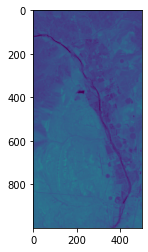

<AxesSubplot:>

In [80]:
show(arrSWIR[0][500:1500,4500:5000])

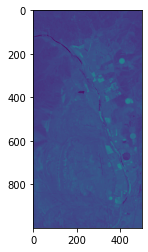

<AxesSubplot:>

In [94]:
show(arrNIRrs[0][500:1500,4500:5000])

### 3.5 NDMI Computation and Presentation

We computated the NDMI based on the formula provided in the introduction section. Then we displayed the pixel values using a histrogram to confirm they fall in the expected numeric range within a reasonable distribution. Finally, we constructed a coloured map using NDMI values as the final product of the project. 

In [81]:
arrNDMI = NID_gen(arrNIRrs[0][500:1500,4500:5000],arrSWIR[0][500:1500,4500:5000])

Text(0.5, 1.0, 'histogram')

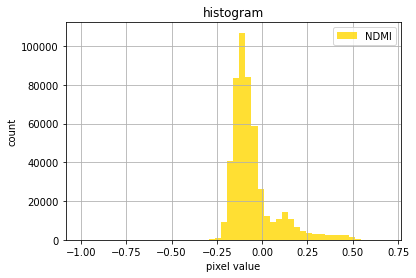

In [82]:
fig, axhist = plt.subplots(1, 1)
show_hist(arrNDMI,bins=50, lw=0.0, stacked=False, alpha=0.8,
          histtype='stepfilled', label=["NDMI"],ax=axhist)
axhist.set_xlabel('pixel value')
axhist.set_ylabel('count')
axhist.set_title('histogram')

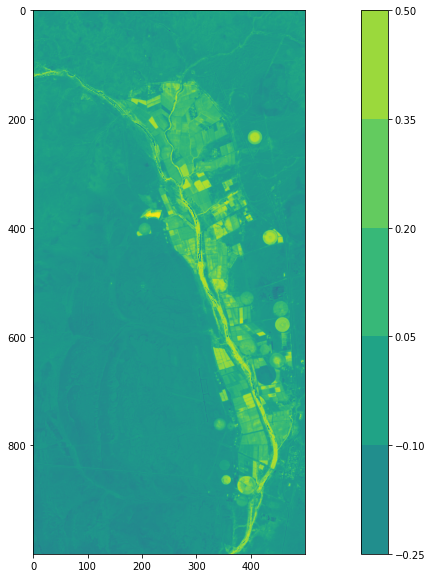

<AxesSubplot:>

In [128]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
image_hidden = ax.imshow(arrNDMI)
fig.colorbar(image_hidden, ax=ax,boundaries=np.linspace(-0.25,0.5,6))
show(arrNDMI)

As the figure above shows, the agricultural belts along river banks have higher water content than that in the areas far away from the banks. 

# Conclusion

In this exercise, we have demonstrated the concept of NDMI through analysing two Sentinel2 images that captured a region in the vicinity of Mariental, Namibia. We organised our workflow into three main steps. 

1) querying and downloading satellite images  
2) loading images to the jupyter environment and performing analysis
3) rendering the computed NDMI as a coloured map 

The work flow of this project is rather generic. It can be adapted to meet other relevant computational needs in geoscience. 